In [196]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import math
plt.style.use("ggplot")

In [197]:
df_raw=yf.download("BTC-USD",progress=False)

# PERIOD

In [198]:

year_start = '2020'
year_end = '2021'
df = df_raw.loc[f'{year_start}-01-01':f'{year_end}-01-01']

# INDICATORS

In [199]:
#MOVING AVG
df["SMA21"]=df["Close"].rolling(21).mean()
df["SMA9"]=df["Close"].rolling(9).mean()
df["SMA30"]=df["Close"].rolling(30).mean()
df["SMA10"]=df["Close"].rolling(10).mean()
df["Relation"]=df["SMA9"]/df["SMA21"]

#BOLLINGER
df["SMA20"]=df["Close"].rolling(20).mean()
df["stdClose20"]=df["Close"].rolling(20).std()

#RSI
df["Diff"]=df["Close"].diff(1)
df["Positive"]=df["Diff"]
df["Negative"]=df["Diff"]
df.loc[df["Diff"]<0,"Positive"]=0
df.loc[df["Diff"]>0,"Negative"]=0
df["Negative"]=abs(df["Negative"])
df["PosSum20"]=df["Positive"].rolling(14).sum()
df["NegSum20"]=df["Negative"].rolling(14).sum()
df["RSI"]=100-100/(1+(df["PosSum20"]/df["NegSum20"]))
prev=None
for i in df.index:
    if(prev!=None):
        condition1=((df.loc[df.index==prev, "RSI"].values[0]<70) and (df.loc[df.index==i, "RSI"].values[0]>=70))
        condition2=((df.loc[df.index==prev, "RSI"].values[0]>30) and (df.loc[df.index==i, "RSI"].values[0]<=30))
        df.loc[i, "transp"] = 0
        df.loc[i, "3070POINTS"] = "blue"
        if condition1: df.loc[i, "3070POINTS"] = "red"  #top
        if condition1: df.loc[i, "transp"] = 1  #top
        if condition2: df.loc[i, "3070POINTS"] = "green"  #bottom
        if condition2: df.loc[i, "transp"] = 1  #bottom
    else:
        df.loc[i, "transp"] = 0
        df.loc[i, "3070POINTS"] = "blue"
    prev=i

df = df.dropna()


<ipython-input-199-8fa549c60f05>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["SMA21"]=df["Close"].rolling(21).mean()
<ipython-input-199-8fa549c60f05>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["SMA9"]=df["Close"].rolling(9).mean()
<ipython-input-199-8fa549c60f05>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

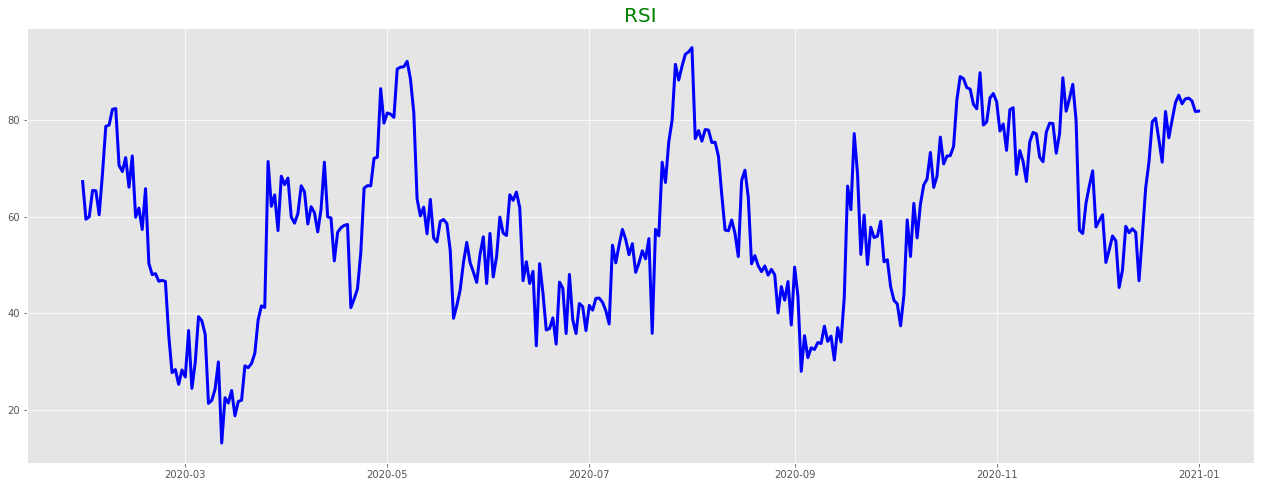

In [200]:
plt.figure(figsize=(22,8))
plt.plot(df["RSI"],color="blue",linewidth=3)
plt.title("RSI",fontsize=20,color="green")

plt.show()

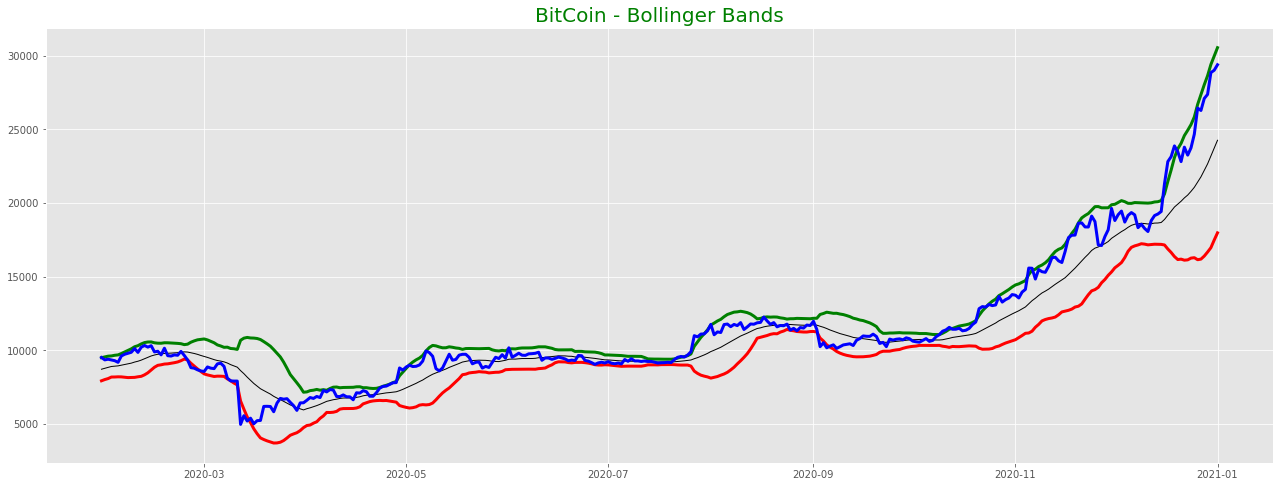

In [201]:
plt.figure(figsize=(22,8))
plt.plot(df["SMA20"]+2*df["stdClose20"],color="green",linewidth=3)
plt.plot(df["SMA20"]-2*df["stdClose20"],color="red",linewidth=3)
plt.plot(df["SMA20"],color="black",linewidth=1)
plt.plot(df["Close"],color="blue",linewidth=3)
plt.title("BitCoin - Bollinger Bands",fontsize=20,color="green")

plt.show()

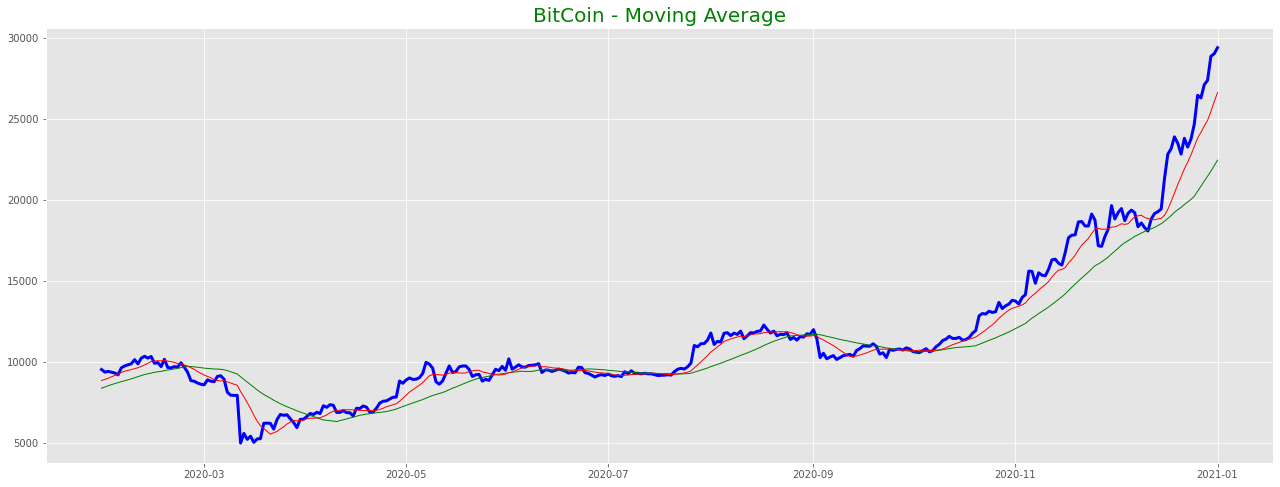

In [202]:
plt.figure(figsize=(22,8))
plt.plot(df["Close"],color="blue",linewidth=3)
plt.plot(df["SMA30"],color="green",linewidth=1)
plt.plot(df["SMA10"],color="red",linewidth=1)
plt.title("BitCoin - Moving Average",fontsize=20,color="green")

plt.show()

# STRATEGY

In [203]:
Buy, Sell = [],[]
# cash_data_data=[df.index[0]]
df_log=pd.DataFrame()
signal=0
initial_cash=1000000
cash=initial_cash
amount=cash
cash_data=[cash]
orders=0
for i in range(len(df["Close"])):
    if (df["Relation"].iloc[i]>1.02) and signal==0:
        signal+=1
        Buy.append(i)
        comission=0.01*df["Open"].iloc[i+1]
        maximo=math.trunc((cash/(df["Open"].iloc[i+1]+comission)))
        cash-=maximo*(df["Open"].iloc[i+1]+comission)
        price=(df["Open"].iloc[i+1])
        a_row=pd.Series(["Buy",df.index[i+1],price,maximo,price*maximo,comission])
        row_df=pd.DataFrame([a_row])
        df_log = pd.concat([row_df, df_log], ignore_index=True)  
        orders+=1
    # elif df["SMA20"].iloc[i]+2*df["stdClose20"].iloc[i]<df["Close"].iloc[i] and signal==0:
    #     signal+=1
    #     Buy.append(i)
    #     comission=0.01*df["Open"].iloc[i+1]
    #     maximo=math.trunc((cash/(df["Open"].iloc[i+1]+comission)))
    #     cash-=maximo*(df["Open"].iloc[i+1]+comission)
    #     price=(df["Open"].iloc[i+1])
    #     a_row=pd.Series(["Buy",df.index[i+1],price,maximo,price*maximo,comission])
    #     row_df=pd.DataFrame([a_row])
    #     df_log = pd.concat([row_df, df_log], ignore_index=True) 
        
    if df["Relation"].iloc[i]<0.98 and signal==1:
        signal=0
        Sell.append(i)
        comission=0.01*df["Open"].iloc[i+1]
        cash+=maximo*(df["Open"].iloc[i+1]+comission)
        cash_data.append(cash)
        price=(df["Open"].iloc[i+1])
        a_row=pd.Series(["Sell",df.index[i+1],price,maximo,price*maximo,comission])
        row_df=pd.DataFrame([a_row])
        df_log = pd.concat([row_df, df_log], ignore_index=True)  
        orders+=1

In [204]:
df_log=df_log[::-1]
df_log=df_log.rename(columns={0:"Type",1:"Date",2:"Price",3:"Quantity",4:"Total",5:"Comissions"})
df_log=df_log.set_index("Date")
df_log

,Type,Price,Quantity,Total,Comissions
Date,,,,,
2020-02-02,Buy,9389.820312,105,9.859311e+05,93.898203
2020-02-27,Sell,8825.093750,105,9.266348e+05,88.250938
2020-03-30,Buy,5925.538574,157,9.303096e+05,59.255386
2020-09-05,Sell,10512.530273,157,1.650467e+06,105.125303
2020-09-23,Buy,10535.492188,156,1.643537e+06,105.354922


In [205]:
# if df_log.iloc[-1]["Type"]=="Buy":
#     df_log=df_log.iloc[:-1]
#     Buy=Buy[:-1]

# BUY&HOLD

In [206]:
buy_hold=[]
datas_buy_hold=[]
shares=df_log["Quantity"][0]
for a in range(len(df)):
    buy_hold.append(df["Close"].iloc[a]*shares)
    datas_buy_hold.append(df.index[a])
minimo_buy_hold=min(buy_hold)
buy_hold=pd.DataFrame(pd.Series(buy_hold))
datas_buy_hold=pd.DataFrame(pd.Series(datas_buy_hold))
buy_hold["Datas"]=datas_buy_hold
buy_hold=buy_hold.set_index("Datas")

# STRATEGY RESULTS DATAFRAME

In [207]:
min_budget=min(cash_data)
current_buy=cash+df_log["Quantity"].iloc[-1]*df["Open"].iloc[-1]
cash_data.append(current_buy)
cash_data=pd.DataFrame(pd.Series(cash_data, name="Amount"))
t_f=df_log["Type"]=="Sell"
cash_data_data=df_log[t_f]
cash_data_data=cash_data_data.index.tolist()
cash_data_data.append(df.index[0])
cash_data_data.append(df.index[-1])
cash_data_data.sort()
print(cash_data_data)
cash_data_data=pd.DataFrame(pd.Series(cash_data_data))
cash_data["Dates"]=cash_data_data
cash_data=cash_data.set_index("Dates")

[Timestamp('2020-01-30 00:00:00'), Timestamp('2020-02-27 00:00:00'), Timestamp('2020-09-05 00:00:00'), Timestamp('2021-01-01 00:00:00')]


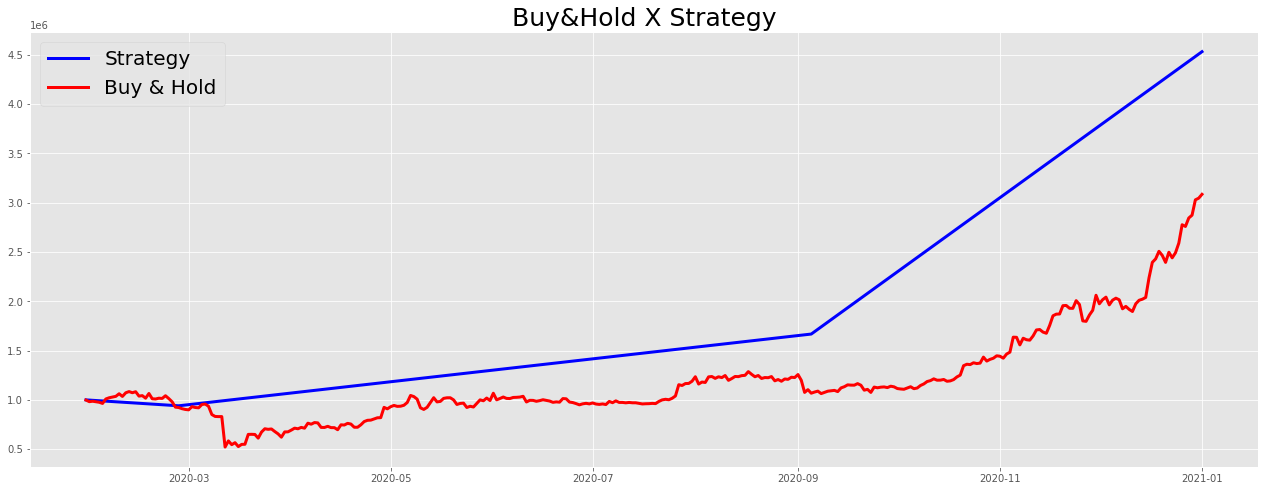

In [208]:
plt.figure(figsize=(22,8))
plt.plot(cash_data,color="blue",label="Strategy",linewidth=3)
plt.plot(buy_hold,color="red",label="Buy & Hold",linewidth=3)
plt.title("Buy&Hold X Strategy",fontsize=25)
plt.legend(fontsize=20)
plt.show()

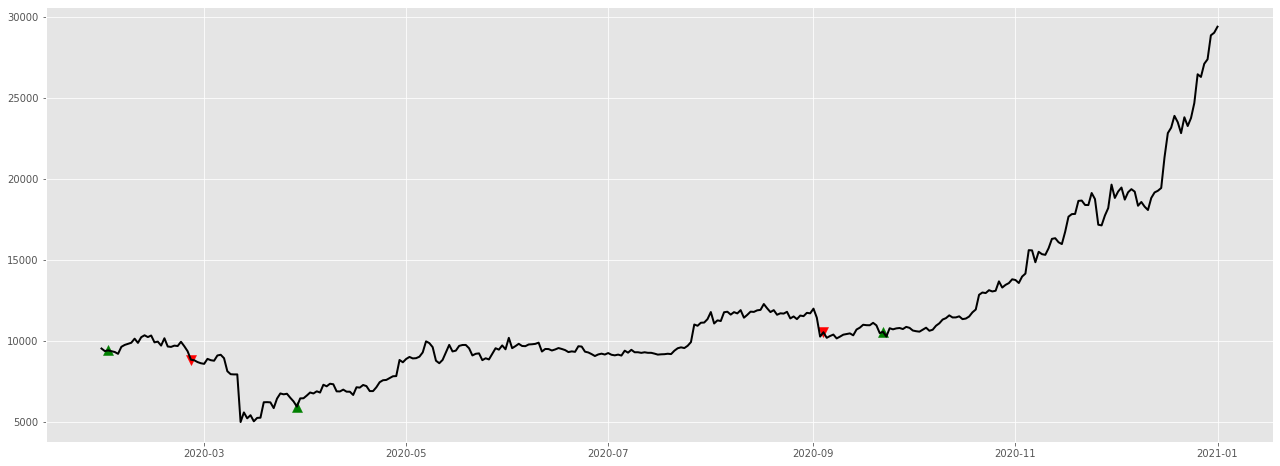

In [209]:
plt.figure(figsize=(22,8))
plt.scatter(df.iloc[Buy].index, df.iloc[Buy]["Adj Close"], marker="^", color="green",s=100)
plt.scatter(df.iloc[Sell].index, df.iloc[Sell]["Adj Close"], marker="v", color="red",s=100)
plt.plot(df["Adj Close"], label="Price", color="k",linewidth =2)

In [210]:
print(f"Period: {df.index.day[0]}/{df.index.month[0]}/{df.index.year[0]} - {df.index.day[-1]}/{df.index.month[-1]}/{df.index.year[-1]}")
print("-="*15)
print(f'{cash_data.iloc[-2][0]:.2f}')
strategy_return=cash_data.iloc[-2][0]/cash_data.iloc[0][0].round(2)
print(f"Strategy Total Return: {(cash_data.iloc[-2][0]/cash_data.iloc[0][0])*100:.2f}%")
x=df["Close"][-1]/df["Close"][0]
print(f"Buy & Hold Total Return {(x*100):.2f}% ")
print("-="*15)
print(f"Strategy Annual Return: {(((1+strategy_return)**(252/len(df))-1)*100):.2f}%")
print(f"Buy & Hold Annual Return: {(((1+x)**(252/len(df))-1)*100):.2f}%")
print("-="*15)
print(f"Orders: {orders}")
print(f"Orders/Year: {orders/(len(df)/252)}")
print("-="*15)
print(f"Maximum Strategy drawdown: {(((min_budget-amount)/amount)*100):.2f}%")
print(f"Maximum Buy & Hold drawdown: {(((min(buy_hold[0])-amount)/amount)*100)}%")

Period: 30/1/2020 - 1/1/2021
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
1667470.02
Strategy Total Return: 166.75%
Buy & Hold Total Return 308.91% 
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Strategy Annual Return: 107.82%
Buy & Hold Annual Return: 185.76%
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Orders: 5
Orders/Year: 3.7278106508875744
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Maximum Strategy drawdown: -5.99%
Maximum Buy & Hold drawdown: -47.80672509765625%


In [211]:
import vectorbt as vbt

price = vbt.YFData.download('BTC-USD', interval="1d").get('Close')

In [212]:


pf = vbt.Portfolio.from_holding(price, init_cash=1000)
pf.plot()


FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'na…

In [213]:
pf.total_profit()

44435.81512274087

In [214]:
Sma20 = vbt.MA.run(price, 20)
Sma10 = vbt.MA.run(price, 10)
buy = Sma10.ma_above(Sma20)
sell = Sma20.ma_above(Sma10)


In [215]:
pf = vbt.Portfolio.from_signals(price, buy, sell, sl_stop=0.005)

In [216]:
pf.plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'na…

In [217]:
pf.total_profit()

7966.81904796561

In [218]:
pf = vbt.Portfolio.from_signals(price, buy, sell)

In [219]:
pf.plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'na…

In [220]:
pf.total_profit()

11194.54426914102